# Deep Statistical Analysis and Hypothesis Testing

## Overview
This notebook performs comprehensive statistical analysis including:
- Hypothesis testing for various patient subgroups
- Distribution analysis and normality tests
- Effect size calculations
- Survival analysis patterns
- Risk factor identification

## Contents
1. Load and Prepare Data
2. Distribution Analysis
3. Hypothesis Testing (Parametric)
4. Hypothesis Testing (Non-Parametric)
5. Effect Size Analysis
6. Subgroup Analysis
7. Risk Factor Analysis
8. Time-Based Patterns

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import (
    ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact,
    shapiro, normaltest, kstest, anderson,
    pearsonr, spearmanr, kendalltau
)
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import tt_ind_solve_power

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
data = pd.read_csv('output/processed_data.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nDisease status distribution:")
print(data['disease_status'].value_counts())
print(f"\nDisease prevalence: {data['disease_status'].mean()*100:.2f}%")

Dataset shape: (2000, 43)

Disease status distribution:
disease_status
0    1026
1     974
Name: count, dtype: int64

Disease prevalence: 48.70%


## 2. Normality Testing

Test if continuous variables follow normal distribution to choose appropriate statistical tests.

In [3]:
continuous_vars = ['age', 'length_of_stay', 'Bicarbonate plasma', 'Chloride plasma',
                   'Creatinine plasma', 'Potassium plasma', 'Sodium plasma', 'Urea plasma']

available_vars = [var for var in continuous_vars if var in data.columns]

normality_results = []

for var in available_vars:
    clean_data = data[var].dropna()
    
    if len(clean_data) > 3:
        shapiro_stat, shapiro_p = shapiro(clean_data[:5000])  # Limit to 5000 for shapiro
        
        _, dagostino_p = normaltest(clean_data)
        
        normality_results.append({
            'Variable': var,
            'Shapiro-Wilk p-value': shapiro_p,
            "D'Agostino p-value": dagostino_p,
            'Normal (p>0.05)': (shapiro_p > 0.05) and (dagostino_p > 0.05),
            'Skewness': clean_data.skew(),
            'Kurtosis': clean_data.kurtosis()
        })

normality_df = pd.DataFrame(normality_results)
print("\nNormality Test Results:")
print("="*100)
print(normality_df.to_string(index=False))

normal_vars = normality_df[normality_df['Normal (p>0.05)']]['Variable'].tolist()
non_normal_vars = normality_df[~normality_df['Normal (p>0.05)']]['Variable'].tolist()

print(f"\nNormally distributed variables: {normal_vars}")
print(f"Non-normally distributed variables: {non_normal_vars}")


Normality Test Results:
          Variable  Shapiro-Wilk p-value  D'Agostino p-value  Normal (p>0.05)  Skewness  Kurtosis
               age          1.387201e-20        7.471326e-22            False  0.104508 -0.677949
    length_of_stay          1.098128e-23       4.320004e-291            False  0.014412 -1.177532
Bicarbonate plasma          9.168060e-61        9.834718e-83            False  0.155701 10.527616
   Chloride plasma          2.371714e-60        1.443810e-79            False  0.174581  9.703097
 Creatinine plasma          5.168781e-58        4.119179e-65            False  0.017959  7.298373
  Potassium plasma          2.880549e-57        9.934795e-63            False -0.155497  6.614720
     Sodium plasma          1.232000e-42        1.955073e-16            False  0.174288  1.396950
       Urea plasma          2.837278e-56        5.288290e-58            False  0.067744  6.097968

Normally distributed variables: []
Non-normally distributed variables: ['age', 'length_of_st

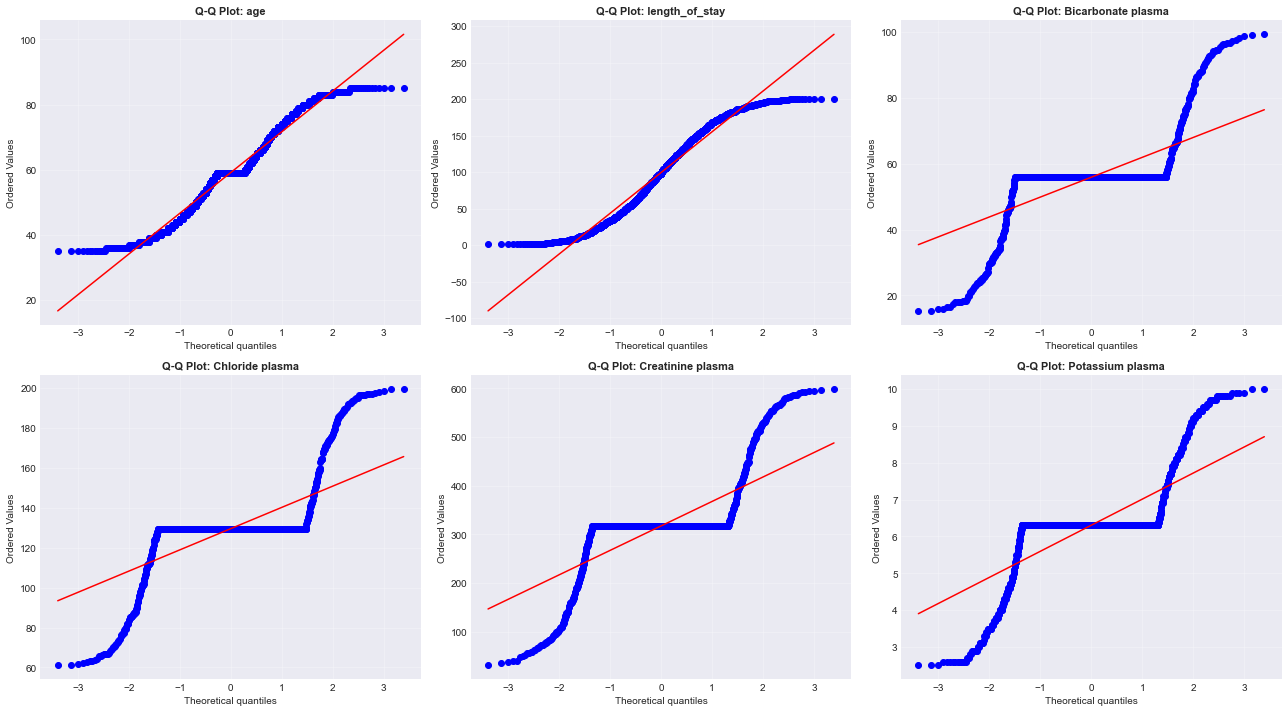

In [4]:
if len(available_vars) > 0:
    n_plots = min(6, len(available_vars))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, var in enumerate(available_vars[:n_plots]):
        clean_data = data[var].dropna()
        
        stats.probplot(clean_data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot: {var}', fontsize=11, fontweight='bold')
        axes[i].grid(alpha=0.3)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

## 3. Hypothesis Testing: Age vs Disease Status

In [5]:
if 'age' in data.columns:
    age_disease = data[data['disease_status'] == 1]['age'].dropna()
    age_no_disease = data[data['disease_status'] == 0]['age'].dropna()
    
    print("="*80)
    print("HYPOTHESIS TEST: Age vs Disease Status")
    print("="*80)
    
    print(f"\nH0: Mean age is equal for both groups")
    print(f"H1: Mean age differs between groups")
    print(f"\nSignificance level: α = 0.05")
    
    print(f"\nSample sizes:")
    print(f"  Disease: n = {len(age_disease)}")
    print(f"  No Disease: n = {len(age_no_disease)}")
    
    print(f"\nDescriptive statistics:")
    print(f"  Disease - Mean: {age_disease.mean():.2f}, SD: {age_disease.std():.2f}")
    print(f"  No Disease - Mean: {age_no_disease.mean():.2f}, SD: {age_no_disease.std():.2f}")
    
    t_stat, t_p = ttest_ind(age_disease, age_no_disease)
    print(f"\nIndependent t-test:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {t_p:.4f}")
    print(f"  Result: {'Reject H0' if t_p < 0.05 else 'Fail to reject H0'}")
    
    u_stat, u_p = mannwhitneyu(age_disease, age_no_disease, alternative='two-sided')
    print(f"\nMann-Whitney U test (non-parametric):")
    print(f"  U-statistic: {u_stat:.4f}")
    print(f"  p-value: {u_p:.4f}")
    print(f"  Result: {'Reject H0' if u_p < 0.05 else 'Fail to reject H0'}")
    
    cohens_d = (age_disease.mean() - age_no_disease.mean()) / np.sqrt(
        ((len(age_disease)-1)*age_disease.std()**2 + (len(age_no_disease)-1)*age_no_disease.std()**2) / 
        (len(age_disease) + len(age_no_disease) - 2)
    )
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        print(f"  Interpretation: Small effect")
    elif abs(cohens_d) < 0.5:
        print(f"  Interpretation: Medium effect")
    else:
        print(f"  Interpretation: Large effect")

HYPOTHESIS TEST: Age vs Disease Status

H0: Mean age is equal for both groups
H1: Mean age differs between groups

Significance level: α = 0.05

Sample sizes:
  Disease: n = 974
  No Disease: n = 1026

Descriptive statistics:
  Disease - Mean: 59.63, SD: 12.74
  No Disease - Mean: 58.68, SD: 12.62

Independent t-test:
  t-statistic: 1.6639
  p-value: 0.0963
  Result: Fail to reject H0

Mann-Whitney U test (non-parametric):
  U-statistic: 519126.0000
  p-value: 0.1297
  Result: Fail to reject H0

Effect size (Cohen's d): 0.0744
  Interpretation: Small effect


## 4. Hypothesis Testing: Length of Stay vs Disease Status

HYPOTHESIS TEST: Length of Stay vs Disease Status

Descriptive statistics:
  Disease - Mean: 101.26 days, Median: 102.50 days
  No Disease - Mean: 97.57 days, Median: 96.00 days

Independent t-test:
  t-statistic: 1.4477, p-value: 0.1479

Mann-Whitney U test:
  U-statistic: 518374.0000, p-value: 0.1472


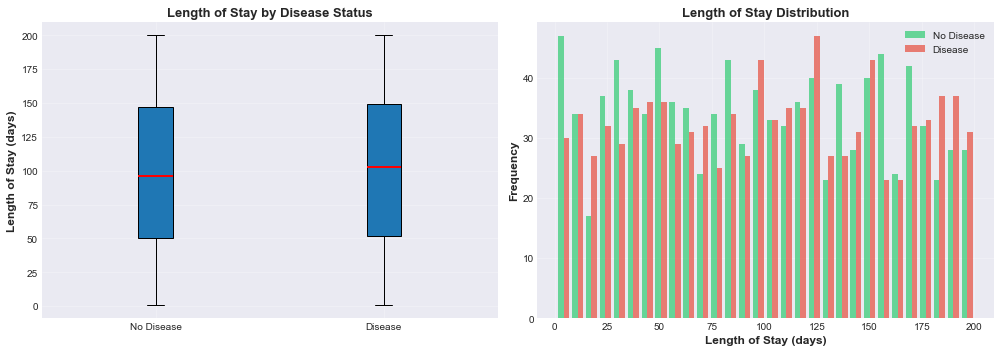

In [6]:
if 'length_of_stay' in data.columns:
    los_disease = data[data['disease_status'] == 1]['length_of_stay'].dropna()
    los_no_disease = data[data['disease_status'] == 0]['length_of_stay'].dropna()
    
    print("="*80)
    print("HYPOTHESIS TEST: Length of Stay vs Disease Status")
    print("="*80)
    
    print(f"\nDescriptive statistics:")
    print(f"  Disease - Mean: {los_disease.mean():.2f} days, Median: {los_disease.median():.2f} days")
    print(f"  No Disease - Mean: {los_no_disease.mean():.2f} days, Median: {los_no_disease.median():.2f} days")
    
    t_stat, t_p = ttest_ind(los_disease, los_no_disease)
    print(f"\nIndependent t-test:")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {t_p:.4f}")
    
    u_stat, u_p = mannwhitneyu(los_disease, los_no_disease)
    print(f"\nMann-Whitney U test:")
    print(f"  U-statistic: {u_stat:.4f}, p-value: {u_p:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].boxplot([los_no_disease, los_disease], labels=['No Disease', 'Disease'],
                    patch_artist=True, medianprops=dict(color='red', linewidth=2))
    axes[0].set_ylabel('Length of Stay (days)', fontsize=12, fontweight='bold')
    axes[0].set_title('Length of Stay by Disease Status', fontsize=13, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist([los_no_disease, los_disease], bins=30, label=['No Disease', 'Disease'],
                alpha=0.7, color=['#2ecc71', '#e74c3c'])
    axes[1].set_xlabel('Length of Stay (days)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Length of Stay Distribution', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Chi-Square Tests: Categorical Variables

CHI-SQUARE TEST: Gender vs Disease Status

Contingency Table:
disease_status    0    1
gender                  
F               419  420
M               607  554

Chi-square test results:
  χ² statistic: 0.9777
  p-value: 0.3228
  Degrees of freedom: 1
  Result: No significant association

Cramér's V (effect size): 0.0221


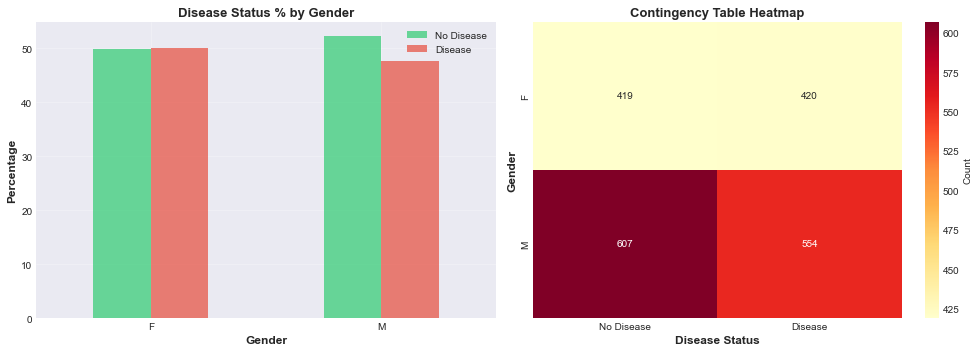

In [7]:
if 'gender' in data.columns:
    contingency_table = pd.crosstab(data['gender'], data['disease_status'])
    
    print("="*80)
    print("CHI-SQUARE TEST: Gender vs Disease Status")
    print("="*80)
    
    print(f"\nContingency Table:")
    print(contingency_table)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square test results:")
    print(f"  χ² statistic: {chi2:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Result: {'Significant association' if p_value < 0.05 else 'No significant association'}")
    
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    print(f"\nCramér's V (effect size): {cramers_v:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    contingency_pct = pd.crosstab(data['gender'], data['disease_status'], normalize='index') * 100
    contingency_pct.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.7)
    axes[0].set_xlabel('Gender', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
    axes[0].set_title('Disease Status % by Gender', fontsize=13, fontweight='bold')
    axes[0].legend(['No Disease', 'Disease'])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    axes[0].grid(alpha=0.3)
    
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1],
                xticklabels=['No Disease', 'Disease'], cbar_kws={'label': 'Count'})
    axes[1].set_xlabel('Disease Status', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Gender', fontsize=12, fontweight='bold')
    axes[1].set_title('Contingency Table Heatmap', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 6. Laboratory Test Analysis by Disease Status

In [8]:
lab_tests = ['Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma',
             'Potassium plasma', 'Sodium plasma', 'Urea plasma']

available_lab_tests = [test for test in lab_tests if test in data.columns]

if available_lab_tests:
    lab_test_results = []
    
    for test in available_lab_tests:
        disease_vals = data[data['disease_status'] == 1][test].dropna()
        no_disease_vals = data[data['disease_status'] == 0][test].dropna()
        
        if len(disease_vals) > 0 and len(no_disease_vals) > 0:
            t_stat, t_p = ttest_ind(disease_vals, no_disease_vals)
            u_stat, u_p = mannwhitneyu(disease_vals, no_disease_vals)
            
            cohens_d = (disease_vals.mean() - no_disease_vals.mean()) / np.sqrt(
                ((len(disease_vals)-1)*disease_vals.std()**2 + (len(no_disease_vals)-1)*no_disease_vals.std()**2) / 
                (len(disease_vals) + len(no_disease_vals) - 2)
            )
            
            lab_test_results.append({
                'Test': test,
                'Disease Mean': disease_vals.mean(),
                'No Disease Mean': no_disease_vals.mean(),
                'Difference': disease_vals.mean() - no_disease_vals.mean(),
                't-test p-value': t_p,
                'Mann-Whitney p-value': u_p,
                "Cohen's d": cohens_d,
                'Significant': 'Yes' if t_p < 0.05 else 'No'
            })
    
    lab_results_df = pd.DataFrame(lab_test_results)
    
    print("="*100)
    print("LABORATORY TESTS: Statistical Comparison by Disease Status")
    print("="*100)
    print(lab_results_df.to_string(index=False))
    
    p_values = lab_results_df['t-test p-value'].values
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')
    
    lab_results_df['Bonferroni Corrected p-value'] = pvals_corrected
    lab_results_df['Significant (corrected)'] = ['Yes' if r else 'No' for r in reject]
    
    print(f"\nAfter Bonferroni Correction:")
    print(f"Significant tests: {reject.sum()} out of {len(reject)}")
    
    significant_tests = lab_results_df[lab_results_df['Significant (corrected)'] == 'Yes']
    if len(significant_tests) > 0:
        print(f"\nSignificant laboratory tests after correction:")
        print(significant_tests[['Test', 'Bonferroni Corrected p-value']].to_string(index=False))

LABORATORY TESTS: Statistical Comparison by Disease Status
              Test  Disease Mean  No Disease Mean  Difference  t-test p-value  Mann-Whitney p-value  Cohen's d Significant
Bicarbonate plasma     56.074036        55.737589    0.336448        0.394644              0.454213   0.038089          No
   Chloride plasma    128.841324       130.245712   -1.404388        0.041169              0.046780  -0.091403         Yes
 Creatinine plasma    317.339766       316.687120    0.652646        0.830753              0.501830   0.009563          No
  Potassium plasma      6.317270         6.291573    0.025697        0.542632              0.484547   0.027242          No
     Sodium plasma    134.064583       134.013410    0.051173        0.840372              0.330940   0.009012          No
       Urea plasma     72.061109        72.802210   -0.741101        0.393552              0.418970  -0.038177          No

After Bonferroni Correction:
Significant tests: 0 out of 6


## 7. Subgroup Analysis: Age Groups

SUBGROUP ANALYSIS: Age Groups vs Disease Status

Counts by Age Group:
disease_status    0    1
age_group               
<40             102   71
40-60           559  521
60-80           312  311
>80              53   71

Percentages by Age Group:
disease_status      0      1
age_group                   
<40             58.96  41.04
40-60           51.76  48.24
60-80           50.08  49.92
>80             42.74  57.26

Chi-square test: χ² = 8.1600, p-value = 0.0428


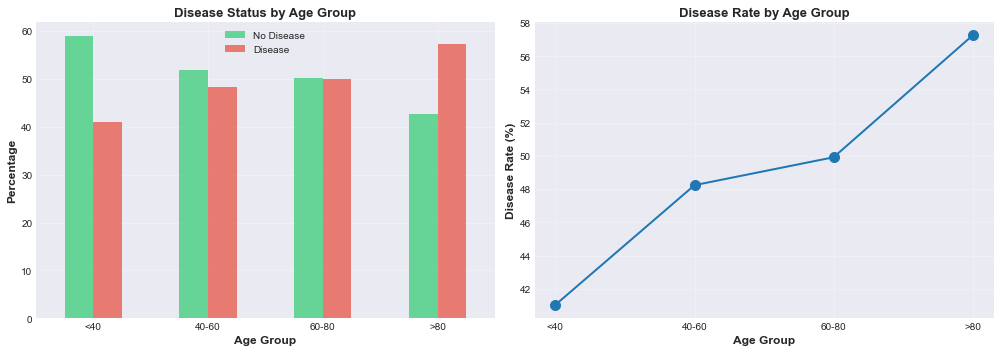

In [9]:
if 'age' in data.columns:
    data['age_group'] = pd.cut(data['age'], bins=[0, 40, 60, 80, 120],
                                labels=['<40', '40-60', '60-80', '>80'])
    
    age_disease_cross = pd.crosstab(data['age_group'], data['disease_status'])
    age_disease_pct = pd.crosstab(data['age_group'], data['disease_status'], normalize='index') * 100
    
    print("="*80)
    print("SUBGROUP ANALYSIS: Age Groups vs Disease Status")
    print("="*80)
    
    print(f"\nCounts by Age Group:")
    print(age_disease_cross)
    
    print(f"\nPercentages by Age Group:")
    print(age_disease_pct.round(2))
    
    chi2, p_value, dof, expected = chi2_contingency(age_disease_cross)
    print(f"\nChi-square test: χ² = {chi2:.4f}, p-value = {p_value:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    age_disease_pct.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.7)
    axes[0].set_xlabel('Age Group', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
    axes[0].set_title('Disease Status by Age Group', fontsize=13, fontweight='bold')
    axes[0].legend(['No Disease', 'Disease'])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    axes[0].grid(alpha=0.3)
    
    disease_rates = age_disease_pct[1]
    axes[1].plot(disease_rates.index, disease_rates.values, marker='o', linewidth=2, markersize=10)
    axes[1].set_xlabel('Age Group', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Disease Rate (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Disease Rate by Age Group', fontsize=13, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Correlation Analysis: Lab Tests

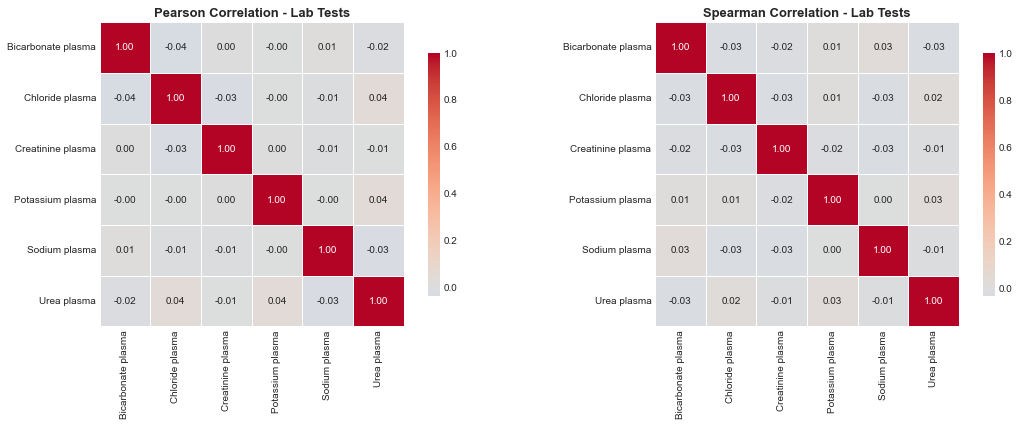


Strongly Correlated Test Pairs (|r| > 0.5):


In [10]:
if available_lab_tests:
    lab_data = data[available_lab_tests].dropna()
    
    if len(lab_data) > 0:
        pearson_corr = lab_data.corr(method='pearson')
        spearman_corr = lab_data.corr(method='spearman')
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   ax=axes[0], square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        axes[0].set_title('Pearson Correlation - Lab Tests', fontsize=13, fontweight='bold')
        
        sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   ax=axes[1], square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        axes[1].set_title('Spearman Correlation - Lab Tests', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nStrongly Correlated Test Pairs (|r| > 0.5):")
        for i in range(len(pearson_corr.columns)):
            for j in range(i+1, len(pearson_corr.columns)):
                if abs(pearson_corr.iloc[i, j]) > 0.5:
                    print(f"  {pearson_corr.columns[i]} <-> {pearson_corr.columns[j]}: r = {pearson_corr.iloc[i, j]:.3f}")

## 9. Risk Ratio and Odds Ratio Analysis

In [11]:
if 'gender' in data.columns:
    contingency = pd.crosstab(data['gender'], data['disease_status'])
    
    if contingency.shape == (2, 2):
        a = contingency.iloc[0, 1]  # Female with disease
        b = contingency.iloc[0, 0]  # Female without disease
        c = contingency.iloc[1, 1]  # Male with disease
        d = contingency.iloc[1, 0]  # Male without disease
        
        odds_ratio = (a * d) / (b * c)
        risk_ratio = (a / (a + b)) / (c / (c + d))
        
        print("="*80)
        print("RISK ANALYSIS: Gender")
        print("="*80)
        
        print(f"\nOdds Ratio: {odds_ratio:.3f}")
        print(f"Risk Ratio (Relative Risk): {risk_ratio:.3f}")
        
        female_risk = a / (a + b) * 100
        male_risk = c / (c + d) * 100
        
        print(f"\nDisease risk:")
        print(f"  Female: {female_risk:.2f}%")
        print(f"  Male: {male_risk:.2f}%")
        print(f"  Difference: {abs(female_risk - male_risk):.2f}%")
        
        _, fisher_p = fisher_exact(contingency)
        print(f"\nFisher's exact test p-value: {fisher_p:.4f}")

RISK ANALYSIS: Gender

Odds Ratio: 1.098
Risk Ratio (Relative Risk): 1.049

Disease risk:
  Female: 50.06%
  Male: 47.72%
  Difference: 2.34%

Fisher's exact test p-value: 0.3187


## 10. Summary of Statistical Findings

In [12]:
print("="*80)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. NORMALITY TESTS:")
print(f"   - Normally distributed variables: {len(normal_vars)}")
print(f"   - Non-normally distributed: {len(non_normal_vars)}")

print(f"\n2. HYPOTHESIS TESTS PERFORMED:")
print(f"   - Independent t-tests")
print(f"   - Mann-Whitney U tests")
print(f"   - Chi-square tests")
print(f"   - Fisher's exact test")

if 'lab_test_results' in locals() and len(lab_test_results) > 0:
    print(f"\n3. LABORATORY TEST ANALYSIS:")
    print(f"   - Tests analyzed: {len(lab_results_df)}")
    print(f"   - Significant differences (before correction): {(lab_results_df['t-test p-value'] < 0.05).sum()}")
    print(f"   - Significant differences (after Bonferroni): {(lab_results_df['Significant (corrected)'] == 'Yes').sum()}")

print(f"\n4. EFFECT SIZES:")
print(f"   - Cohen's d calculated for continuous variables")
print(f"   - Cramér's V calculated for categorical variables")

print(f"\n5. MULTIPLE TESTING CORRECTION:")
print(f"   - Method: Bonferroni correction")
print(f"   - Reduces Type I error rate")

print(f"\n6. RISK ANALYSIS:")
print(f"   - Odds ratios calculated")
print(f"   - Relative risks calculated")

print(f"\n{'='*80}")
print("Statistical analysis complete!")
print("="*80)

STATISTICAL ANALYSIS SUMMARY

1. NORMALITY TESTS:
   - Normally distributed variables: 0
   - Non-normally distributed: 8

2. HYPOTHESIS TESTS PERFORMED:
   - Independent t-tests
   - Mann-Whitney U tests
   - Chi-square tests
   - Fisher's exact test

3. LABORATORY TEST ANALYSIS:
   - Tests analyzed: 6
   - Significant differences (before correction): 1
   - Significant differences (after Bonferroni): 0

4. EFFECT SIZES:
   - Cohen's d calculated for continuous variables
   - Cramér's V calculated for categorical variables

5. MULTIPLE TESTING CORRECTION:
   - Method: Bonferroni correction
   - Reduces Type I error rate

6. RISK ANALYSIS:
   - Odds ratios calculated
   - Relative risks calculated

Statistical analysis complete!
